# Description
The notebook contains research to achieve flat predictions on Dense Neural Network


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas
import numpy
import root_numpy

from utils import compute_labels_and_weights, roc_auc_score_one_vs_all
from utils import compute_cvm_by_particle, plot_flatness_by_particle, names_labels_correspondence
from utils import pickle_dt_pid_estimator
from utils import iterate_minibatches
from sklearn.cross_validation import train_test_split

from keras.utils import np_utils

import theano
import theano.tensor as T
import lasagne

import cPickle

Using Theano backend.


## Read features

In [24]:
import json
with open('../data/features.json', 'r') as f:
    feature_families = json.load(f)
original_features = numpy.concatenate(feature_families.values())

## Preparing the data

In [4]:
step = 1

data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree', step=step))
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree', step=step))

In [5]:
data_target = data.MCParticleType.values
data_test_target = data_test.MCParticleType.values

In [6]:
len(data), len(data_test)

(5999993, 5999990)

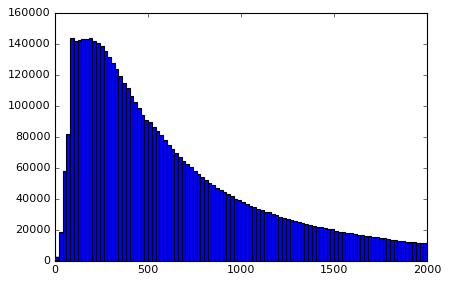

In [7]:
plt.hist(data.TrackPt.values, bins=100, range=(0, 2000));

In [8]:
data.head()

,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,CaloHcalE,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
0,1.028090,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0096,0.0096,0.0532,33.816654,83,0.111340,15.622943,16,37,9099
1,1.044008,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0064,0.0063,0.0358,67.432457,187,0.025907,0.510528,38,106,12220
2,0.853933,-999,-999,-999,0,1,155.237808,1,-1.926180,27002.507812,...,0.0108,0.0108,0.0557,29.747982,67,0.136919,5.520920,14,76,8573
3,1.306180,-999,-999,-999,0,1,11.793685,1,0.434916,0.000000,...,0.0086,0.0084,0.0453,45.295311,97,0.572526,2.692502,25,50,13449
4,0.969101,-999,-999,-999,0,1,113.548508,1,1.788384,0.000000,...,0.0115,0.0110,0.0773,33.635342,71,0.101532,4.014179,24,86,1379


## Preprocess

#### take spectator variables

In [9]:
from utils import compute_eta
eta = compute_eta(data.TrackP, data.TrackPt)
trackP, track_Pt, ntracks = data.TrackP.values, data.TrackPt.values, data.NumProtoParticles.values
eta_test = compute_eta(data_test.TrackP, data_test.TrackPt)
trackP_test, track_Pt_test, ntracks_test = data_test.TrackP.values, data_test.TrackPt.values, data_test.NumProtoParticles.values

#### preprocess

In [10]:
from utils import preprocess
data = preprocess(data[original_features], iron_scaler_path='../models/iron.pkl')
data_test = preprocess(data_test[original_features], iron_scaler_path='../models/iron.pkl')

utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[column] = data[column].astype('float32')


In [11]:
data.shape

(5999993, 80)

#### add spectators to the datasets

In [12]:
data['eta'] = eta
data_test['eta'] = eta_test
data['NumProtoParticles'] = ntracks
data_test['NumProtoParticles'] = ntracks_test

#### add signal column

In [13]:
data_target, _ = compute_labels_and_weights(data_target)
data_test_target, _ = compute_labels_and_weights(data_test_target)

#### number of tracks for each type

In [14]:
for key, val in names_labels_correspondence.items():
    print '{:10} \t'.format(key), sum(data_target == val)

Ghost      	999995
Electron   	1000004
Muon       	1000001
Pion       	1000006
Kaon       	999993
Proton     	999994


## Take section of data

In [4]:
TRAIN_SIZE = 600000
TEST_SIZE = 100000
SEED = 5
data_short, _, data_target_short, _, trackP_short, _, trackPt_short, _ = train_test_split(data, data_target, trackP, track_Pt, train_size=TRAIN_SIZE, random_state=SEED)
data_test_short, _, data_test_target_short, _, trackP_test_short, _, trackPt_test_short, _ = train_test_split(data_test, data_test_target, trackP_test, track_Pt_test, train_size=TEST_SIZE, random_state=SEED)

# Dumping train
data_short.to_csv('data_short.csv', index=None)
numpy.save('data_target_short.npy', data_target_short)
numpy.save('trackP_short.npy', trackP_short)
numpy.save('trackPt_short.npy', trackPt_short)

# Dumping test
data_test_short.to_csv('data_test_short.csv', index=None)
numpy.save('data_test_target_short.npy', data_test_target_short); 
numpy.save('trackP_test_short.npy', trackP_test_short)
numpy.save('trackPt_test_short.npy', trackPt_test_short)

# Loading train
data_short = pandas.read_csv('data_short.csv')
data_target_short = numpy.load('data_target_short.npy')
trackP_short = numpy.load('trackP_short.npy')
trackPt_short = numpy.load('trackPt_short.npy')

# Loading test
data_test_short = pandas.read_csv('data_test_short.csv')
data_test_target_short = numpy.load('data_test_target_short.npy')
trackP_test_short = numpy.load('trackP_test_short.npy')
trackPt_test_short = numpy.load('trackPt_test_short.npy')

## Train NN

In [11]:
n_features = data_short[original_features].shape[1]
n_classes = len(set(data_target_short))

n_classes, n_features

(6, 60)

In [10]:
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, BatchNormLayer, NonlinearityLayer
from lasagne.nonlinearities import softmax, tanh, rectify

input_var = T.matrix('input', dtype='float32')
target_var = T.matrix('signal', dtype='float32')
lr = T.scalar('learning rate')

network = InputLayer(shape=(None, n_features), input_var=input_var)

network = DenseLayer(network, 300, nonlinearity=rectify)
network = DropoutLayer(network, 0.1)

network = DenseLayer(network, 300)
network = BatchNormLayer(network)
network = DropoutLayer(network, 0.3)
network = NonlinearityLayer(network, nonlinearity=rectify)

network = DenseLayer(network, 400, nonlinearity=rectify)
network = DropoutLayer(network, 0.5)

network = DenseLayer(network, n_classes, nonlinearity=softmax)

predictions = lasagne.layers.get_output(network)
params = lasagne.layers.get_all_params(network, trainable=True)
loss = lasagne.objectives.categorical_crossentropy(predictions, target_var)
loss = loss.mean()
acc = T.mean(T.eq(T.argmax(predictions, axis=1), T.argmax(target_var, axis=1)),
                  dtype=theano.config.floatX)

updates = lasagne.updates.rmsprop(loss, params, learning_rate=lr)
train_fn = theano.function([input_var, target_var, lr], [loss, acc], updates=updates, allow_input_downcast=True)
test_fn = theano.function([input_var], [predictions], allow_input_downcast=True)

In [19]:
N_EPOCH = 5
lr = 1e-3
PATIENCE = 5

for epoch in range(N_EPOCH):
    if epoch and epoch % PATIENCE == 0: lr /= 10.0
    for batch_X, batch_y in iterate_minibatches(data_short[original_features].values, np_utils.to_categorical(data_target_short), batch_size=50000):
        loss_value, _ = train_fn(batch_X, batch_y, lr)
    p = test_fn(data_test_short[original_features].values)[0]
    auc = roc_auc_score_one_vs_all(data_test_target_short, p)
    print 'Epoch: %d' % epoch
    print auc

pass

Epoch: 0
                 Ghost             Electron                 Muon  \
0  0.9083 $\pm$ 0.0038  0.9585 $\pm$ 0.0010  0.9680 $\pm$ 0.0012   

                  Pion                 Kaon               Proton  
0  0.9080 $\pm$ 0.0029  0.8435 $\pm$ 0.0023  0.8417 $\pm$ 0.0021  
Epoch: 1
                 Ghost             Electron                 Muon  \
0  0.9263 $\pm$ 0.0032  0.9713 $\pm$ 0.0005  0.9770 $\pm$ 0.0006   

                  Pion                 Kaon               Proton  
0  0.9225 $\pm$ 0.0028  0.8688 $\pm$ 0.0027  0.8606 $\pm$ 0.0045  
Epoch: 2
                 Ghost             Electron                 Muon  \
0  0.9328 $\pm$ 0.0025  0.9764 $\pm$ 0.0007  0.9798 $\pm$ 0.0011   

                  Pion                 Kaon               Proton  
0  0.9292 $\pm$ 0.0030  0.8805 $\pm$ 0.0022  0.8770 $\pm$ 0.0022  
Epoch: 3
                 Ghost             Electron                 Muon  \
0  0.9381 $\pm$ 0.0029  0.9791 $\pm$ 0.0005  0.9816 $\pm$ 0.0006   

              

## Check flatness

#### compute CvM

In [20]:
prediction_2d = test_fn(data_test_short[original_features].values)[0]
compute_cvm_by_particle(data_test_target_short, prediction_2d, 
                        {'TrackP': trackP_test_short, 'TrackPt': trackPt_test_short})

,TrackP,TrackP error,TrackPt,TrackPt error
Ghost,0.003011,0.000688,0.008225,0.001724
Electron,0.010259,0.000629,0.021969,0.000902
Muon,0.036704,0.001748,0.042817,0.001716
Pion,0.014937,0.001015,0.009223,0.000629
Kaon,0.027339,0.002012,0.016976,0.001527
Proton,0.021632,0.001268,0.026562,0.001211


#### visualize non-flatness

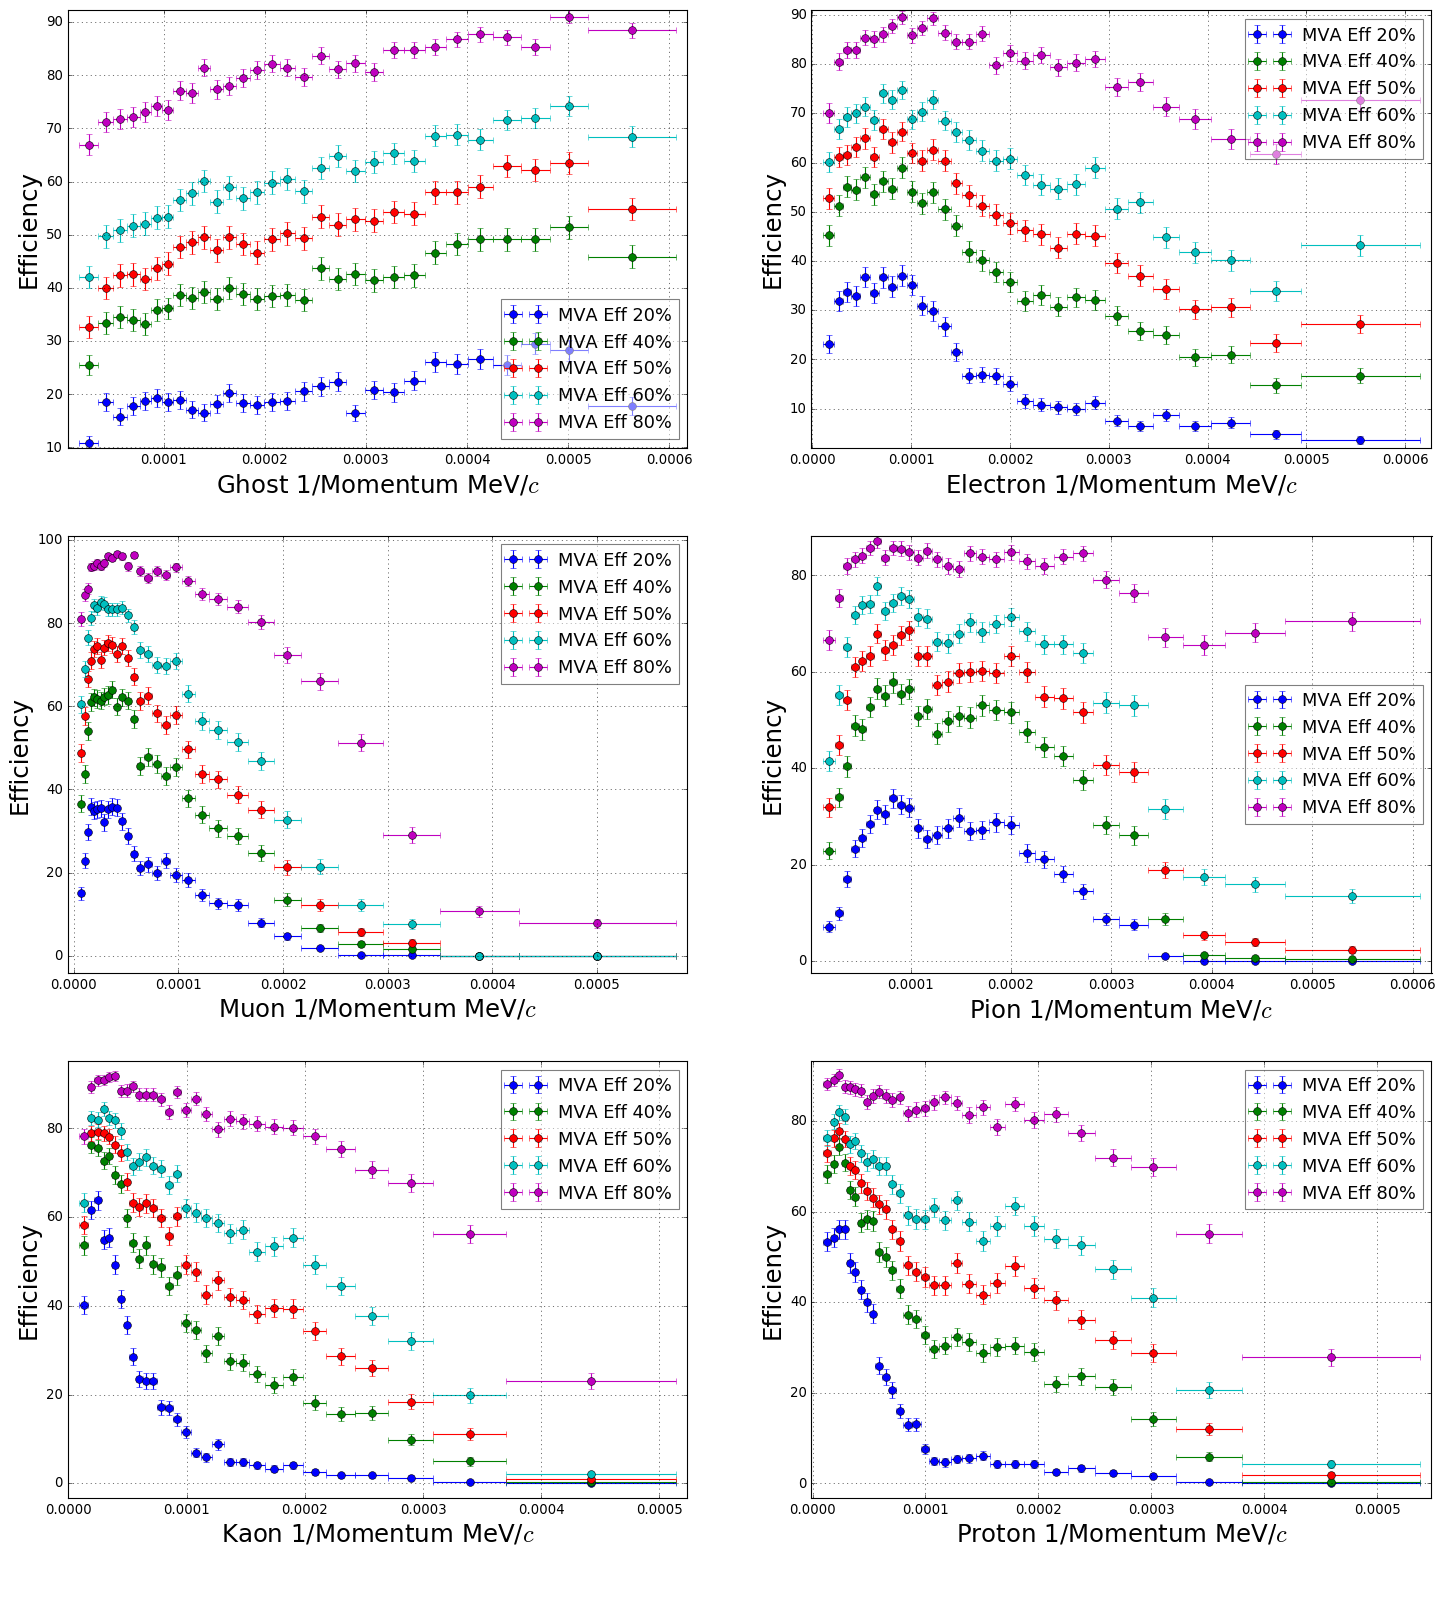

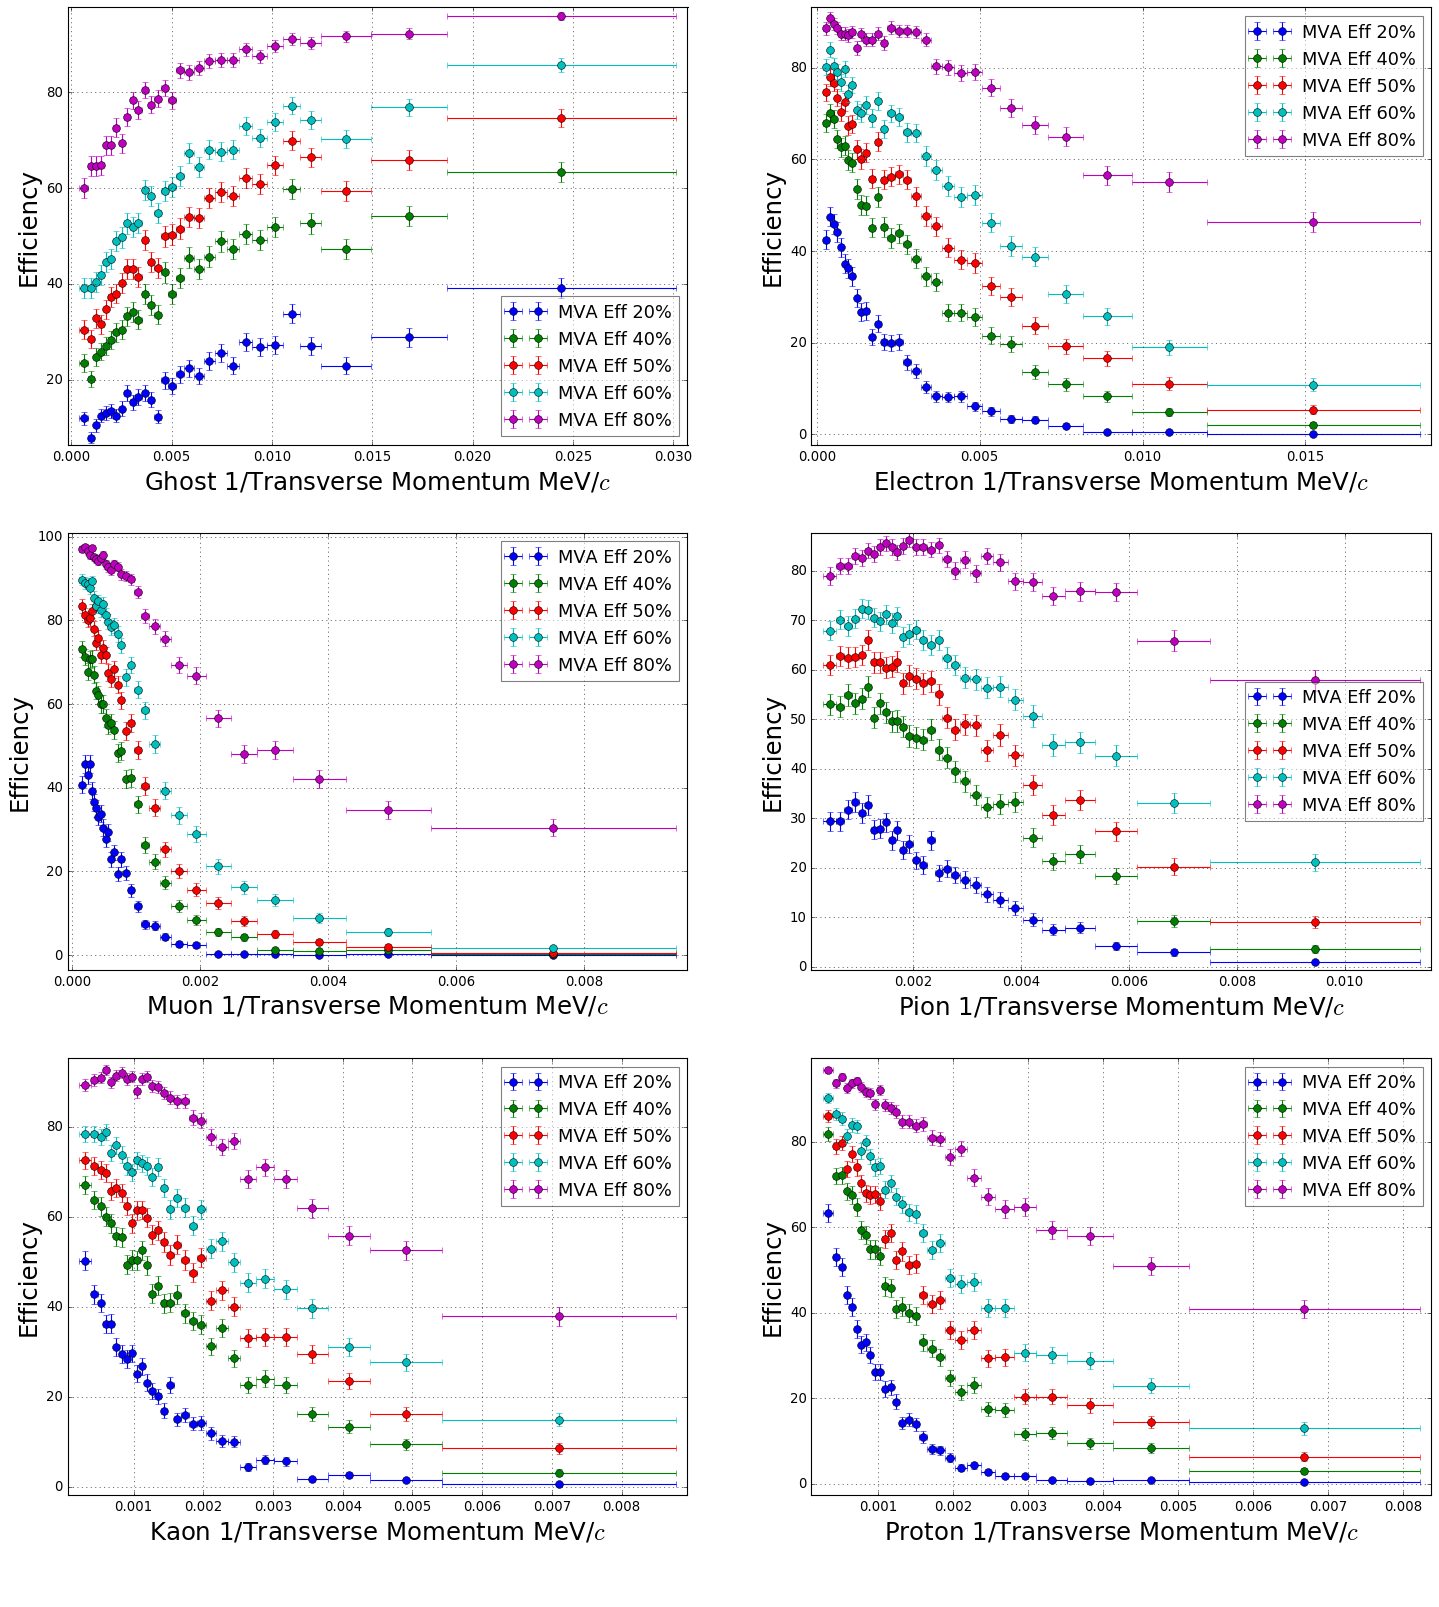

In [21]:
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackP_test_short,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackPt_test_short, 
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)

## Non-Decomposable objective for AUC
from https://arxiv.org/pdf/1608.04802.pdf

#### loss

In [128]:
from theano.tensor.nnet import relu
from lasagne.objectives import multiclass_hinge_loss

def trunc_auc_loss(preds, target, b, l, a, w, d):
    """
    @param preds - predictions (f(x)). [n_samples, n_classes] tensor
    @param target - target label (y).  [n_samples, n_classes] tensor
    @param b - list of b from https://arxiv.org/pdf/1608.04802.pdf (Formula 6). Trainable [n_regions, n_classes] tensor
    @param l - list of \lambda from https://arxiv.org/pdf/1608.04802.pdf (Formula 6). Trainable [n_regions, n_classes] tensor
    @param a - list of \alpha from https://arxiv.org/pdf/1608.04802.pdf (Formula 6).  List of shape [n_regions]
    @param w - list of weights of regions for truncated AUC. List of shape [n_regions]
    @param d - list of \Delta from https://arxiv.org/pdf/1608.04802.pdf (Formula 6). List of shape [n_regions]
    """
    assert len(b) == len(l) == len(a) == len(w), 'lists of variables must have the same shape'
    loss = 0
    Y_plus = relu(target).mean(axis=0)
    for b_, l_, a_, w_ in zip(b, l, a, w):
        b_ = T.tile(b_, [preds.shape[0], 1])
        l_ = T.tile(l_, [preds.shape[0], 1])
        l_plus = T.tile(multiclass_hinge_loss(preds - b_, target), [n_classes, 1]).T * relu(target - 0.5) # Hinge loss along positive samples
        l_minus = T.tile(multiclass_hinge_loss(preds - b_, target), [n_classes, 1]).T * relu(0.5 - target) # Hinge loss along negative samples
        l_plus = l_plus.mean(axis=0); l_minus = l_minus.mean(axis=0)
        loss += w_ * d * ((1 + l_) * l_plus + l_ * (a_/(1.0 - a_)) * l_minus - l_ * Y_plus).mean()

    return loss.mean()

#### NN

In [129]:
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, BatchNormLayer, NonlinearityLayer
from lasagne.nonlinearities import softmax, tanh, rectify

input_var = T.matrix('input', dtype='float32')
target_var = T.matrix('signal', dtype='float32')
lr = T.scalar('learning rate')

network = InputLayer(shape=(None, n_features), input_var=input_var)

network = DenseLayer(network, 300, nonlinearity=rectify)
network = DropoutLayer(network, 0.1)

network = DenseLayer(network, 300)
network = BatchNormLayer(network)
network = DropoutLayer(network, 0.3)
network = NonlinearityLayer(network, nonlinearity=rectify)

network = DenseLayer(network, 400, nonlinearity=rectify)
network = DropoutLayer(network, 0.5)

network = DenseLayer(network, n_classes, nonlinearity=softmax)

predictions = lasagne.layers.get_output(network)
params = lasagne.layers.get_all_params(network, trainable=True)
# loss = lasagne.objectives.categorical_crossentropy(predictions, target_var)
# loss = loss.mean()
b = [lasagne.utils.create_param(numpy.array([0.5] * n_classes), [n_classes], name='b_%d' % i) for i in range(1, 6)]
l = [lasagne.utils.create_param(numpy.array([0.5] * n_classes), [n_classes], name='lambda_%d' % i) for i in range(1, 6)]
a = [0.5, 0.6, 0.7, 0.8, 0.9]
# w = [0.0, 0.5, 1.0, 1.5, 2.0] # for TruncatedAUC
w = numpy.ones_like(a)
d = 0.1
loss = trunc_auc_loss(predictions, target_var, b, l, a, w, d)
acc = T.mean(T.eq(T.argmax(predictions, axis=1), T.argmax(target_var, axis=1)),
                  dtype=theano.config.floatX)

updates_l = lasagne.updates.rmsprop(-loss, l, learning_rate=lr) # maximize
updates_b = lasagne.updates.rmsprop(loss, b, learning_rate=lr)
updates_nn = lasagne.updates.rmsprop(loss, params, learning_rate=lr)

train_l = theano.function([input_var, target_var, lr], [], updates=updates_l, allow_input_downcast=True)
train_b = theano.function([input_var, target_var, lr], [], updates=updates_b, allow_input_downcast=True)
train_nn = theano.function([input_var, target_var, lr], [loss, acc], updates=updates_nn, allow_input_downcast=True)
test_fn = theano.function([input_var], [predictions], allow_input_downcast=True)

def train(X, y, lr):
    train_l(X, y, lr)
    train_b(X, y, lr)
    loss_value, acc_value = train_nn(X, y, lr)
    return loss_value, acc_value

In [130]:
N_EPOCH = 5
lr = 1e-3
PATIENCE = 5

for epoch in range(N_EPOCH):
    if epoch and epoch % PATIENCE == 0: lr /= 10.0
    for batch_X, batch_y in iterate_minibatches(data_short[original_features].values, np_utils.to_categorical(data_target_short), batch_size=50000):
        loss_value, _ = train(batch_X, batch_y, lr)
    p = test_fn(data_test_short[original_features].values)[0]
    auc = roc_auc_score_one_vs_all(data_test_target_short, p)
    print 'Epoch: %d' % epoch
    print auc

pass

Epoch: 0
                 Ghost             Electron                 Muon  \
0  0.8473 $\pm$ 0.0040  0.9257 $\pm$ 0.0011  0.9339 $\pm$ 0.0032   

                  Pion                 Kaon               Proton  
0  0.8675 $\pm$ 0.0024  0.7978 $\pm$ 0.0041  0.8143 $\pm$ 0.0025  
Epoch: 1
                 Ghost             Electron                 Muon  \
0  0.8848 $\pm$ 0.0039  0.9427 $\pm$ 0.0027  0.9488 $\pm$ 0.0027   

                  Pion                 Kaon               Proton  
0  0.8985 $\pm$ 0.0035  0.8405 $\pm$ 0.0021  0.8454 $\pm$ 0.0030  
Epoch: 2
                 Ghost             Electron                 Muon  \
0  0.8971 $\pm$ 0.0047  0.9495 $\pm$ 0.0013  0.9564 $\pm$ 0.0015   

                  Pion                 Kaon               Proton  
0  0.9102 $\pm$ 0.0027  0.8616 $\pm$ 0.0023  0.8583 $\pm$ 0.0032  
Epoch: 3
                 Ghost             Electron                 Muon  \
0  0.9040 $\pm$ 0.0038  0.9527 $\pm$ 0.0017  0.9611 $\pm$ 0.0020   

              

In [132]:
prediction_2d = test_fn(data_test_short[original_features].values)[0]
compute_cvm_by_particle(data_test_target_short, prediction_2d, 
                        {'TrackP': trackP_test_short, 'TrackPt': trackPt_test_short})

,TrackP,TrackP error,TrackPt,TrackPt error
Ghost,0.004685,0.000889,0.010885,0.001307
Electron,0.009391,0.000622,0.014185,0.000875
Muon,0.036853,0.002065,0.033217,0.001175
Pion,0.012630,0.000215,0.007582,0.000709
Kaon,0.024517,0.001863,0.012231,0.001095
Proton,0.020256,0.001155,0.029827,0.000584


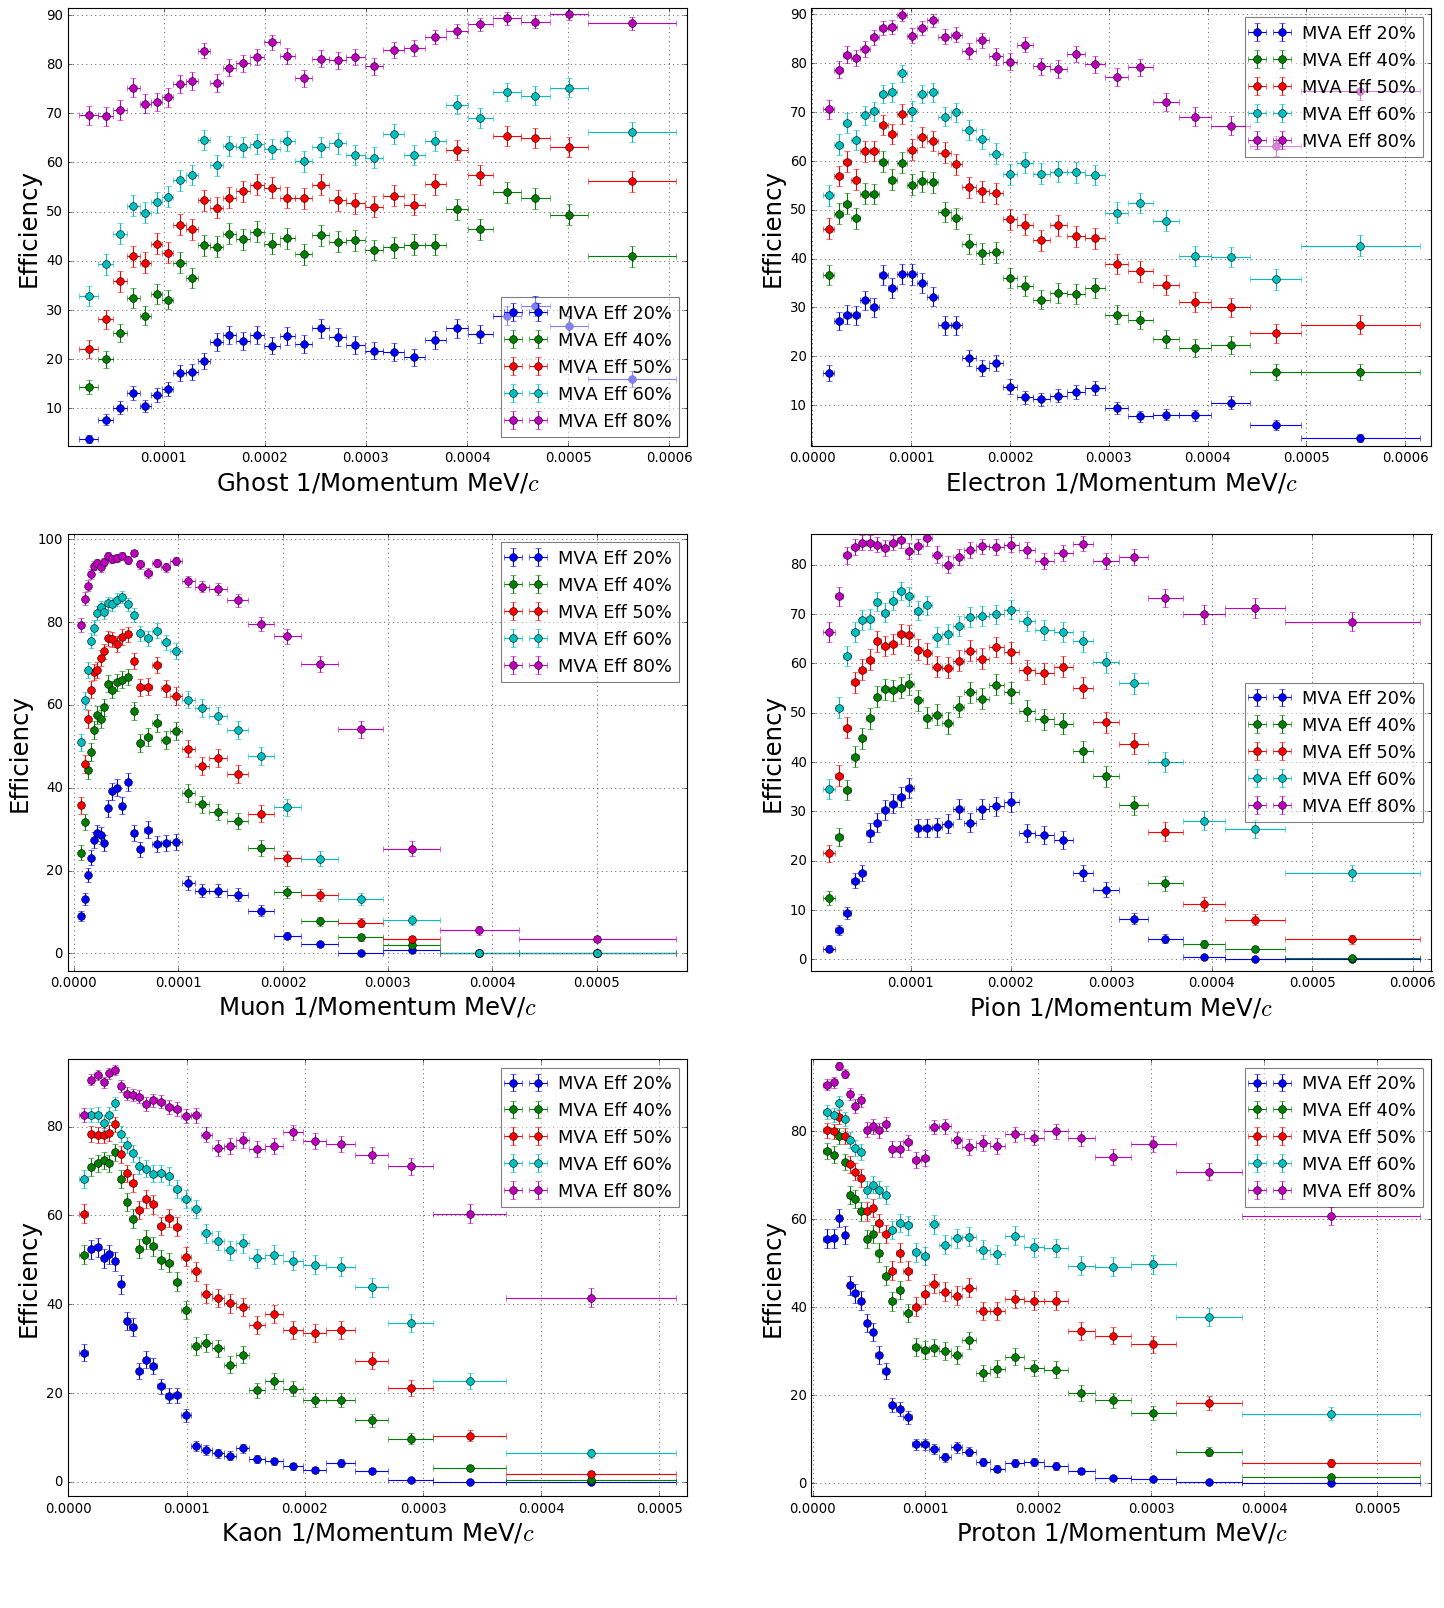

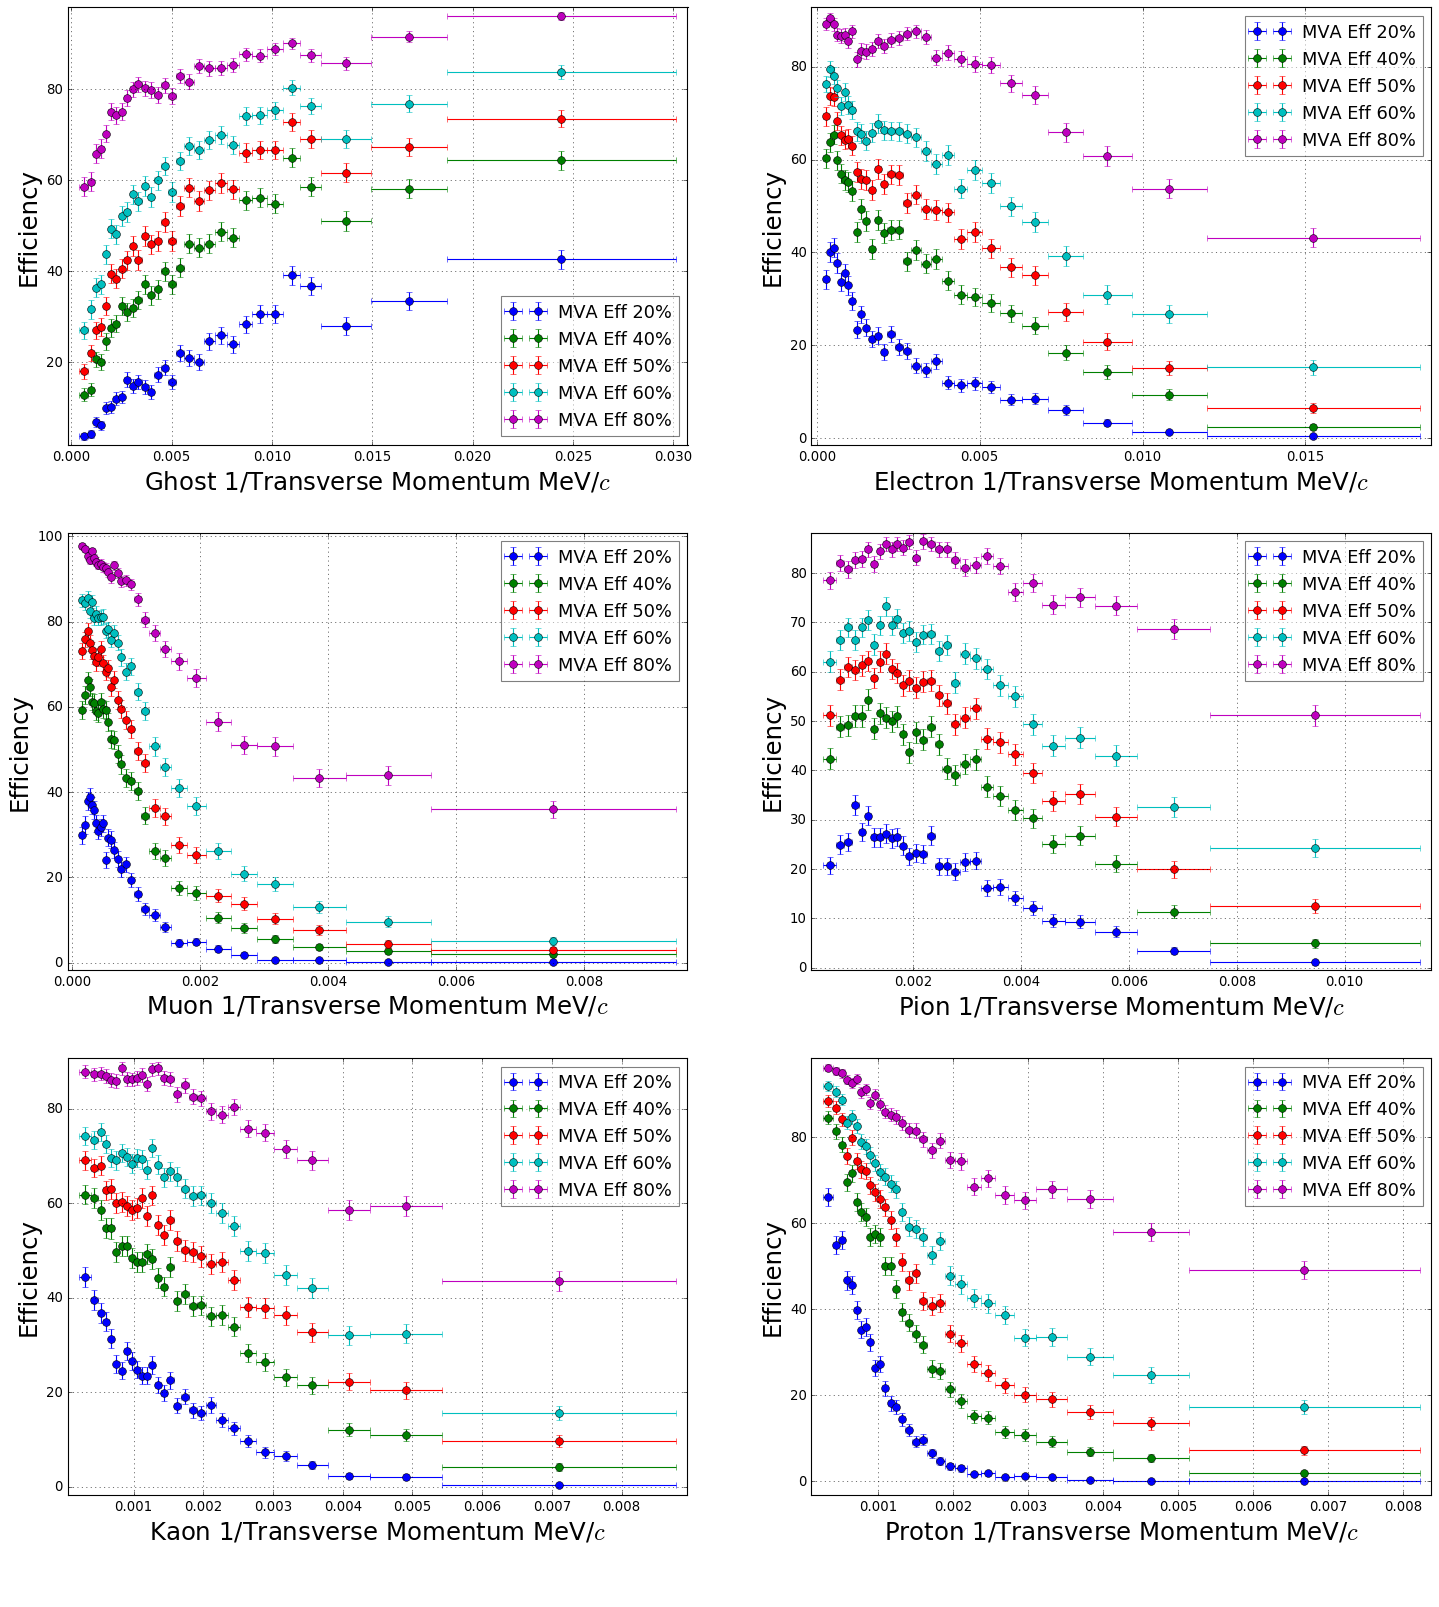

In [133]:
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackP_test_short,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackPt_test_short, 
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)

## Add adversarial decorrelation branch
... from https://indico.cern.ch/event/595059/contributions/2497380/attachments/1431792/2199760/2017.03.22_IML.pdf

In [57]:
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, BatchNormLayer, NonlinearityLayer
from lasagne.nonlinearities import softmax, tanh, rectify

input_var = T.matrix('input', dtype='float32')
target_var = T.matrix('signal', dtype='float32')
flatness_var = T.vector('flatness_var', dtype='float32')
lr = T.scalar('learning rate')

network = InputLayer(shape=(None, n_features), input_var=input_var)

network = DenseLayer(network, 300, nonlinearity=rectify)
network = DropoutLayer(network, 0.1)

network = DenseLayer(network, 300)
network = BatchNormLayer(network)
network = DropoutLayer(network, 0.3)
network = NonlinearityLayer(network, nonlinearity=rectify)

network = DenseLayer(network, 400, nonlinearity=rectify)
network = DropoutLayer(network, 0.5)

network = DenseLayer(network, n_classes, nonlinearity=softmax)

network_p_flatness = DenseLayer(network, 100) # Branch for flatness variable predictions
network_p_flatness = DenseLayer(network_p_flatness, 1, nonlinearity=rectify)

network_pt_flatness = DenseLayer(network, 100) # Branch for flatness variable predictions
network_pt_flatness = DenseLayer(network_pt_flatness, 1, nonlinearity=rectify)

predictions_target = lasagne.layers.get_output(network)
params_target = lasagne.layers.get_all_params(network, trainable=True)
loss_target = lasagne.objectives.categorical_crossentropy(predictions_target, target_var)
loss_target = loss_target.mean()
acc_target = T.mean(T.eq(T.argmax(predictions_target, axis=1), T.argmax(target_var, axis=1)),
                  dtype=theano.config.floatX)

predictions_p_flatness = lasagne.layers.get_output(network_p_flatness)
params_p_flatness = lasagne.layers.get_all_params(network_p_flatness, trainable=True)
loss_p_flatness = - lasagne.objectives.squared_error(predictions_p_flatness, flatness_var)
loss_p_flatness = loss_p_flatness.mean()

predictions_pt_flatness = lasagne.layers.get_output(network_pt_flatness)
params_pt_flatness = lasagne.layers.get_all_params(network_pt_flatness, trainable=True)
loss_pt_flatness = - lasagne.objectives.squared_error(predictions_pt_flatness, flatness_var)
loss_pt_flatness = loss_pt_flatness.mean()

updates_target = lasagne.updates.rmsprop(loss_target, params_target, learning_rate=lr)
updates_p_flatness = lasagne.updates.rmsprop(loss_p_flatness, params_p_flatness, learning_rate=lr)
updates_pt_flatness = lasagne.updates.rmsprop(loss_pt_flatness, params_pt_flatness, learning_rate=lr)

train_target = theano.function([input_var, target_var, lr], [loss_target, acc_target], updates=updates_target, allow_input_downcast=True)
train_p_flatness = theano.function([input_var, flatness_var, lr], [loss_p_flatness], updates=updates_p_flatness, allow_input_downcast=True)
train_pt_flatness = theano.function([input_var, flatness_var, lr], [loss_pt_flatness], updates=updates_pt_flatness, allow_input_downcast=True)
test_fn = theano.function([input_var], [predictions_target], allow_input_downcast=True)

In [58]:
N_EPOCH = 2
lr_target = 1e-3
lr_p = 2 * 1e-3
lr_pt = 2 * 1e-3

DECAY = 5

TRACK_P_BATCH_FREQ = 1 # run "TrackP"-variable flatness learning after each TRACK_P_BATCH_FREQ steps of target train
TRACK_PT_BATCH_FREQ = 1 # run "TrackPt"-variable flatness learning after each TRACK_PT_BATCH_FREQ steps of target train

BATCH_SIZE_TARGET = 50000
BATCH_SIZE_P = 50000
BATCH_SIZE_PT = 50000

step = 0
for epoch in range(N_EPOCH):
    if epoch and epoch % DECAY == 0: 
        lr_target /= 10.0; lr_p /= 10.0; lr_pt /= 10.0
    
    track_p_minibatches_iterator = iterate_minibatches(data_short[original_features].values, trackP_short, batch_size=BATCH_SIZE_P)
    track_pt_minibatches_iterator = iterate_minibatches(data_short[original_features].values, trackPt_short, batch_size=BATCH_SIZE_PT)
    
    for batch_X, batch_y in iterate_minibatches(data_short[original_features].values, np_utils.to_categorical(data_target_short), batch_size=BATCH_SIZE_TARGET):
        step += 1
        
        # Train target
        loss_value, _ = train_target(batch_X, batch_y, lr_target)
        
        # Train TrackP-flatness
        if step % TRACK_P_BATCH_FREQ == 0:
            try: 
                batch_X, batch_y = next(track_p_minibatches_iterator)
                loss_value = train_p_flatness(batch_X, batch_y, lr_p)[0]
            except StopIteration: 
                track_p_minibatches_iterator = iterate_minibatches(data_short[original_features].values, trackP_short, batch_size=BATCH_SIZE_P)
    
        # Train TrackPt-flatness
        if step % TRACK_PT_BATCH_FREQ == 0:
            try: 
                batch_X, batch_y = next(track_pt_minibatches_iterator)
                loss_value = train_pt_flatness(batch_X, batch_y, lr_pt)[0]
            except StopIteration: 
                track_pt_minibatches_iterator = iterate_minibatches(data_short[original_features].values, trackPt_short, batch_size=BATCH_SIZE_PT)
        
    preps = test_fn(data_test_short[original_features].values)[0]
    auc = roc_auc_score_one_vs_all(data_test_target_short, preps)
    cvm = compute_cvm_by_particle(data_test_target_short, preps, 
                        {'TrackP': trackP_test_short, 'TrackPt': trackPt_test_short})
    print 'AUC (epoch %d)' % epoch
    print auc
    print 'CvM (epoch %d)' % epoch
    print cvm

pass

AUC (epoch 0)
                 Ghost             Electron                 Muon  \
0  0.8570 $\pm$ 0.0045  0.9401 $\pm$ 0.0006  0.9332 $\pm$ 0.0023   

                  Pion                 Kaon               Proton  
0  0.8573 $\pm$ 0.0027  0.7960 $\pm$ 0.0008  0.7903 $\pm$ 0.0045  
CvM (epoch 0)
            TrackP  TrackP error   TrackPt  TrackPt error
Ghost     0.002898      0.000417  0.005900       0.000602
Electron  0.004934      0.000483  0.003285       0.000176
Muon      0.020441      0.002108  0.014469       0.001331
Pion      0.009067      0.000385  0.004734       0.000780
Kaon      0.008936      0.000320  0.009130       0.000866
Proton    0.007497      0.000541  0.013344       0.000659
AUC (epoch 1)
                 Ghost             Electron                 Muon  \
0  0.9105 $\pm$ 0.0029  0.9672 $\pm$ 0.0010  0.9671 $\pm$ 0.0013   

                  Pion                 Kaon               Proton  
0  0.9102 $\pm$ 0.0033  0.8436 $\pm$ 0.0012  0.8574 $\pm$ 0.0015  
CvM (epoch

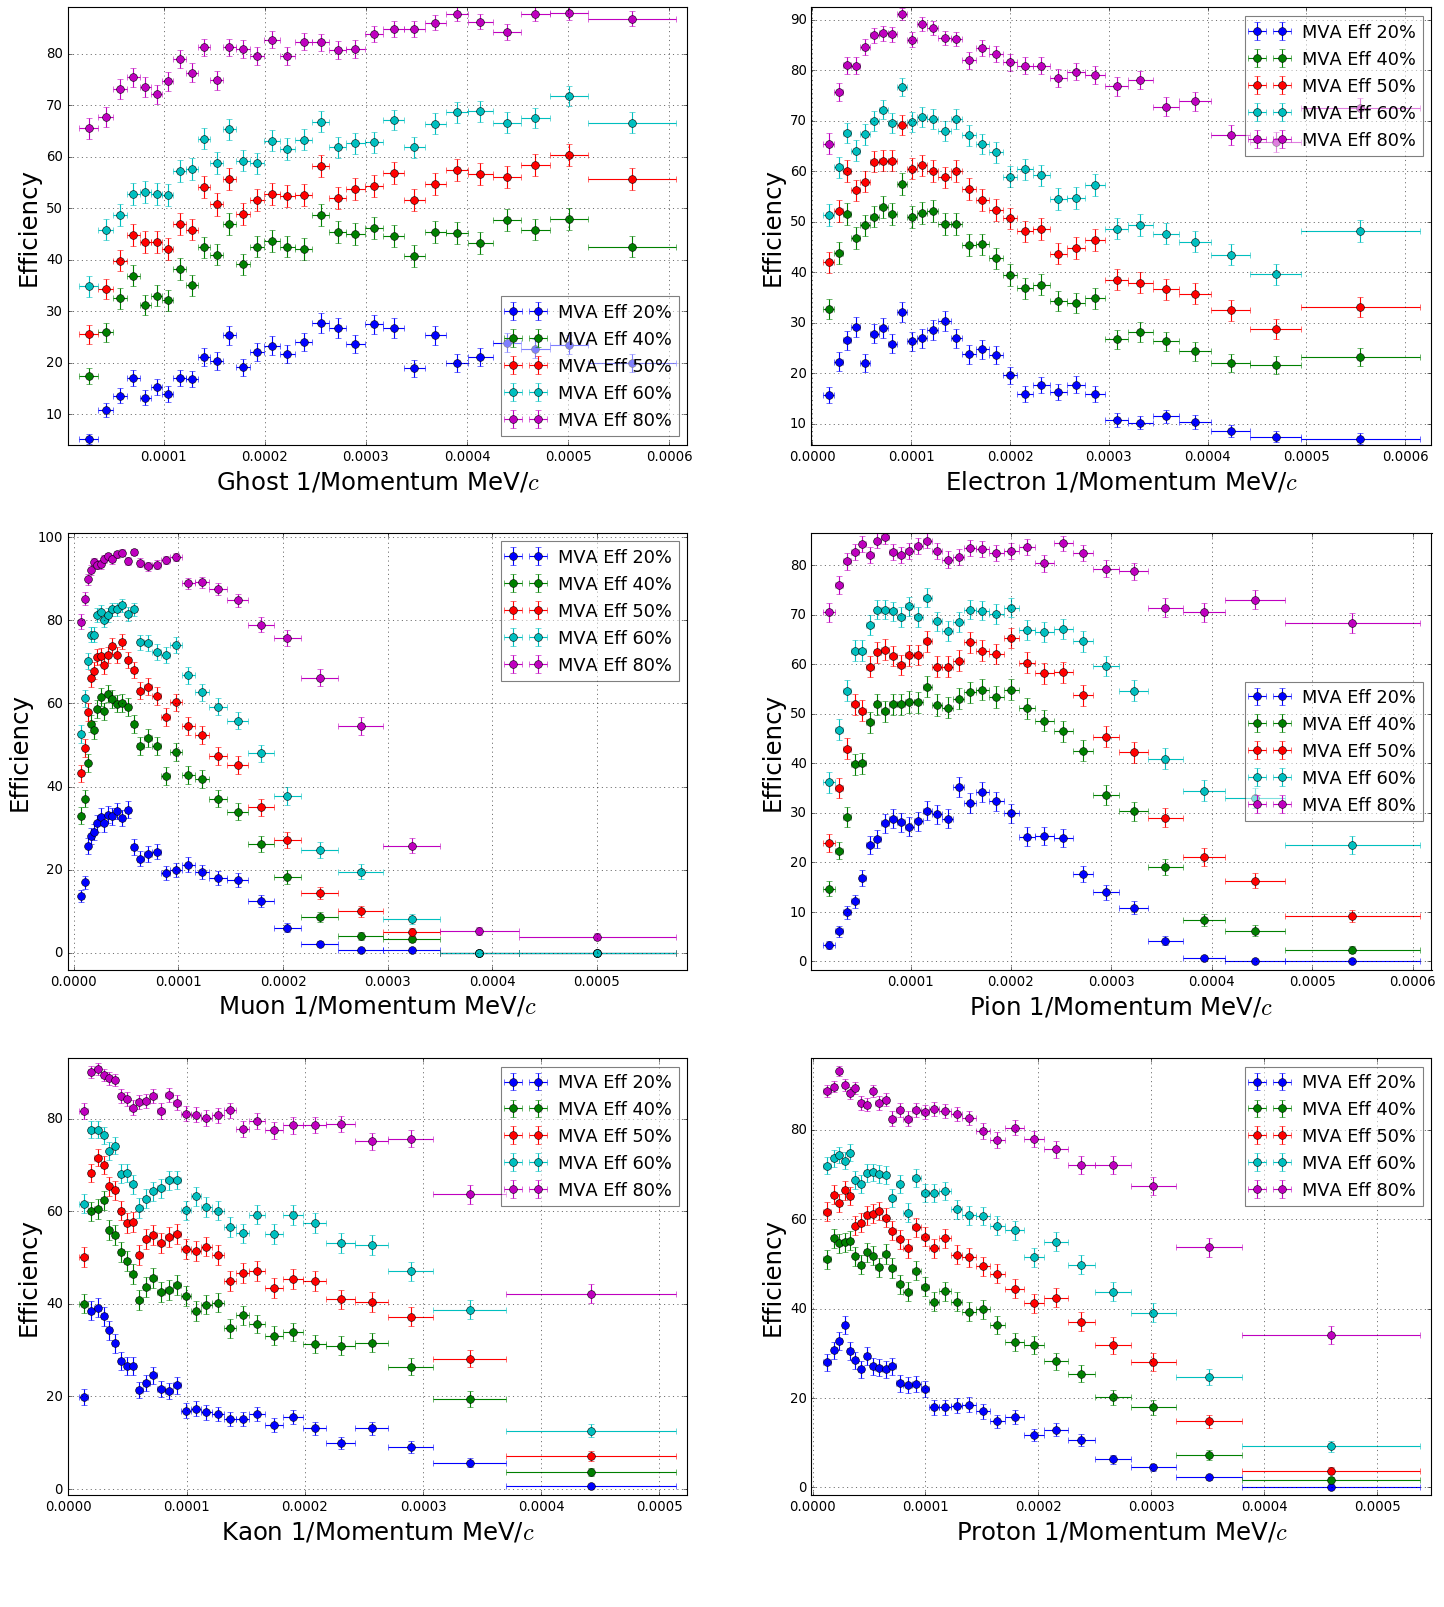

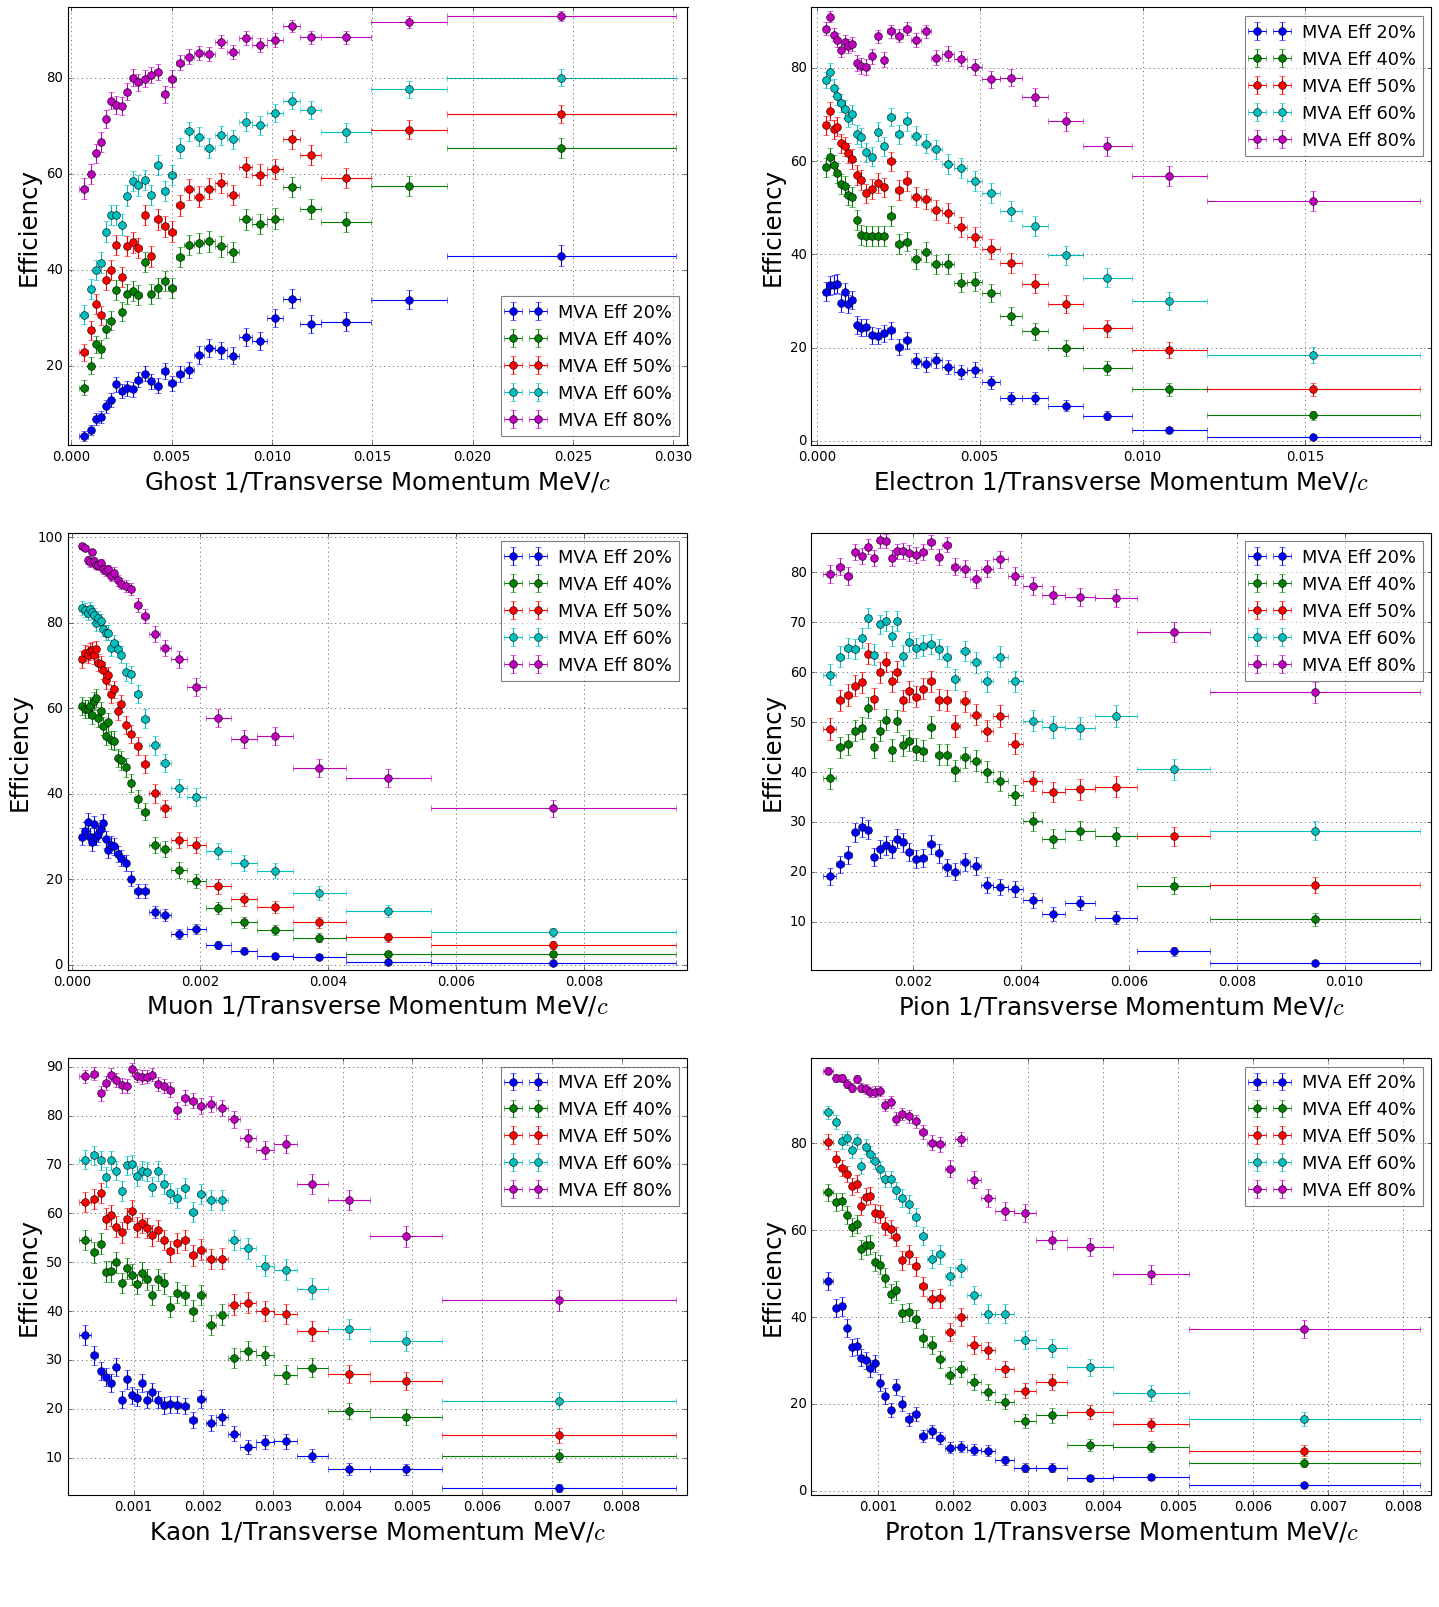

In [59]:
prediction_2d = test_fn(data_test_short[original_features].values)[0]
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackP_test_short,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)
plot_flatness_by_particle(data_test_target_short, prediction_2d, 1./trackPt_test_short, 
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], ignored_sideband=0.01)

## Add flatness loss
... from https://arxiv.org/pdf/1410.4140.pdf

In [134]:
# TODO